In [1]:
import numpy as np 
import pandas as pd 
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import plot_importance
import gc # for deleting unused variables
%matplotlib inline

import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
dtypes = {
        'ip'            : 'uint16',
        'app'           : 'uint16',
        'device'        : 'uint16',
        'os'            : 'uint16',
        'channel'       : 'uint16',
        'is_attributed' : 'uint8',
        'click_id'      : 'uint32' 
        }

# read training_sample.csv for quick testing/debug, else read the full train.csv
testing = True
if testing:
    train_path = "train_sample.csv"
    skiprows = None
    nrows = None
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']
else:
    train_path = "train.csv"
    skiprows = range(1, 144903891)
    nrows = 10000000
    colnames=['ip','app','device','os', 'channel', 'click_time', 'is_attributed']

In [3]:
train_df=pd.read_csv('/home/vinod/Downloads/train_sample.csv',dtype=dtypes)

In [4]:
train_df.head(2)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,40024,25,1,17,259,2017-11-07 13:40:27,NaN,0


In [5]:
train_df.shape

(100000, 8)

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   ip               100000 non-null  uint16
 1   app              100000 non-null  uint16
 2   device           100000 non-null  uint16
 3   os               100000 non-null  uint16
 4   channel          100000 non-null  uint16
 5   click_time       100000 non-null  object
 6   attributed_time  227 non-null     object
 7   is_attributed    100000 non-null  uint8 
dtypes: object(2), uint16(5), uint8(1)
memory usage: 2.6+ MB


In [7]:
train_df.drop(['attributed_time'],axis=1,inplace=True)

In [8]:
train_df.head(2)

,ip,app,device,os,channel,click_time,is_attributed
0,22004,12,1,13,497,2017-11-07 09:30:38,0
1,40024,25,1,17,259,2017-11-07 13:40:27,0


In [9]:
def fraction_unique(x):
    return 
number_unique_vals ={'app': 161,'channel': 161,'click_time': 80350,'device': 100,'ip': 28470,'is_attributed': 2,'os': 130}
print(number_unique_vals)

{'app': 161, 'channel': 161, 'click_time': 80350, 'device': 100, 'ip': 28470, 'is_attributed': 2, 'os': 130}


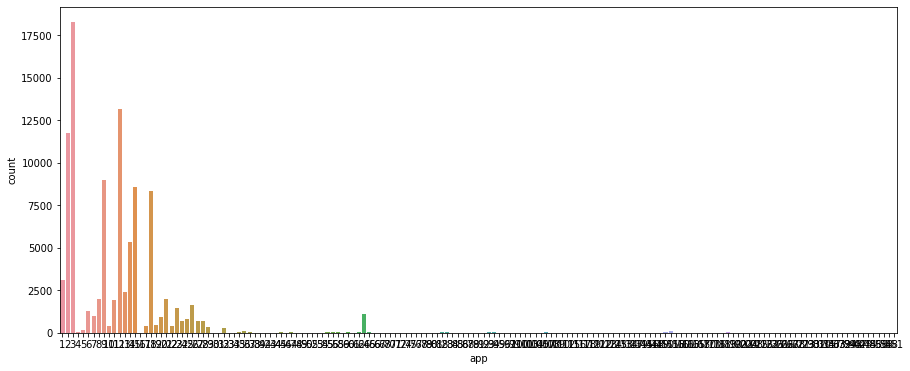

In [10]:
plt.figure(figsize=(15, 6))
sns.countplot(data=train_df,x='app')

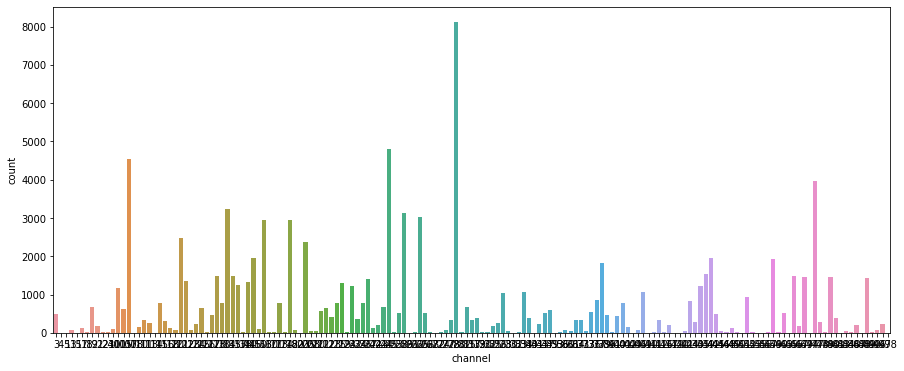

In [11]:
plt.figure(figsize=(15, 6))
sns.countplot(data=train_df,x='channel')

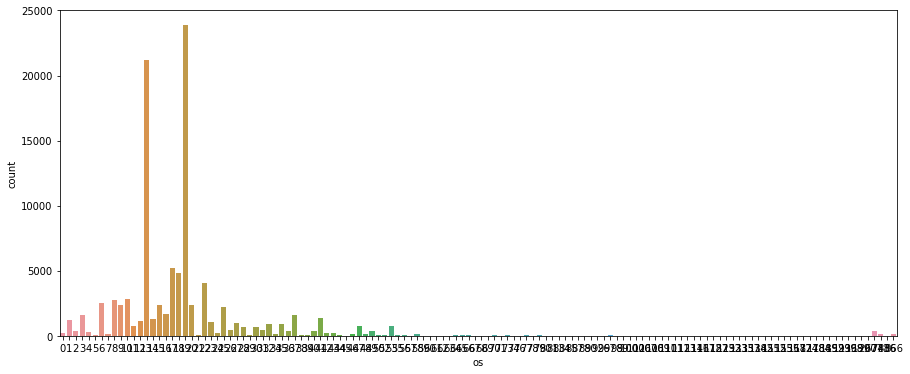

In [12]:
plt.figure(figsize=(15, 6))
sns.countplot(data=train_df,x='os')

In [13]:
train_df['is_attributed'].value_counts()/len(train_df)*100

0    99.773
1     0.227
Name: is_attributed, dtype: float64

In [14]:
train_df.describe()

,ip,app,device,os,channel,is_attributed
count,100000.000000,100000.00000,100000.000000,100000.000000,100000.000000,100000.000000
mean,30943.754230,12.04788,21.771250,22.818280,268.832460,0.002270
std,18651.939203,14.94150,259.667767,55.943136,129.724248,0.047591
min,8.000000,1.00000,0.000000,0.000000,3.000000,0.000000
25%,14290.750000,3.00000,1.000000,13.000000,145.000000,0.000000
50%,31117.000000,12.00000,1.000000,18.000000,258.000000,0.000000
75%,46868.250000,15.00000,1.000000,19.000000,379.000000,0.000000
max,65526.000000,551.00000,3867.000000,866.000000,498.000000,1.000000


In [15]:
app_target =train_df.groupby('app')['is_attributed'].agg(['mean','count'])

In [16]:
app_target

,mean,count
app,,
1,0.000000,3135
2,0.000000,11737
3,0.000219,18279
4,0.000000,58
5,0.074468,188
...,...,...
486,0.000000,1
536,0.000000,1
538,0.000000,1


In [17]:
frequent_apps =app_target['count'].reset_index(drop=True)

In [18]:
frequent_apps=frequent_apps[frequent_apps>80]

In [19]:
frequent_apps=pd.concat([frequent_apps,train_df],axis=1,join='inner')

In [20]:
frequent_apps.head(5)

,count,ip,app,device,os,channel,click_time,is_attributed
0,3135,22004,12,1,13,497,2017-11-07 09:30:38,0
1,11737,40024,25,1,17,259,2017-11-07 13:40:27,0
2,18279,35888,12,1,19,212,2017-11-07 18:05:24,0
4,188,2877,12,1,1,178,2017-11-09 09:00:09,0
5,1303,28127,3,1,17,115,2017-11-09 01:22:13,0


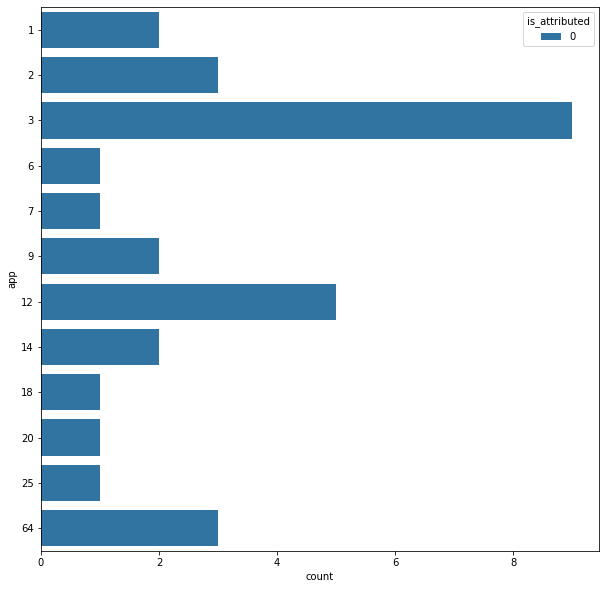

In [21]:
plt.figure(figsize=(10,10))
sns.countplot(data=frequent_apps,y='app',hue='is_attributed')

In [22]:
def timeFeatures(df):
    train_df['datetime'] = pd.to_datetime(train_df['click_time'])
    train_df['day_of_week'] =train_df['datetime'].dt.dayofweek
    train_df["day_of_year"] = train_df['datetime'].dt.dayofyear
    train_df["month"] =train_df['datetime'].dt.month
    train_df["hour"] = train_df['datetime'].dt.hour
    return df

In [23]:
timeFeatures(train_df)

,ip,app,device,os,channel,click_time,is_attributed,datetime,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,2017-11-07 09:30:38,0,2017-11-07 09:30:38,1,311,11,9
1,40024,25,1,17,259,2017-11-07 13:40:27,0,2017-11-07 13:40:27,1,311,11,13
2,35888,12,1,19,212,2017-11-07 18:05:24,0,2017-11-07 18:05:24,1,311,11,18
3,29048,13,1,13,477,2017-11-07 04:58:08,0,2017-11-07 04:58:08,1,311,11,4
4,2877,12,1,1,178,2017-11-09 09:00:09,0,2017-11-09 09:00:09,3,313,11,9
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,59347,11,1,19,122,2017-11-09 13:25:41,0,2017-11-09 13:25:41,3,313,11,13
99996,19614,9,1,13,244,2017-11-07 11:25:43,0,2017-11-07 11:25:43,1,311,11,11
99997,18839,3,1,13,19,2017-11-08 11:38:42,0,2017-11-08 11:38:42,2,312,11,11
99998,48740,15,1,12,245,2017-11-08 17:55:21,0,2017-11-08 17:55:21,2,312,11,17


In [24]:
train_df.drop(['datetime','click_time'],axis=1,inplace=True)

In [25]:
train_df.head(5)

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [26]:
train_df.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week       int64
day_of_year       int64
month             int64
hour              int64
dtype: object

In [27]:
train_df['day_of_week']=train_df['day_of_week'].astype('uint16')
train_df['day_of_year']=train_df['day_of_year'].astype('uint16')
train_df['month']=train_df['month'].astype('uint16')
train_df['hour']=train_df['hour'].astype('uint16')

In [28]:
train_df.dtypes

ip               uint16
app              uint16
device           uint16
os               uint16
channel          uint16
is_attributed     uint8
day_of_week      uint16
day_of_year      uint16
month            uint16
hour             uint16
dtype: object

In [29]:
ip_count =train_df.groupby(['ip']).agg('count')

In [30]:
ip_count=ip_count.drop(['device','os','channel','is_attributed','day_of_week','day_of_year','month','hour'],axis=1)

In [31]:
ip_count=ip_count.rename({'app':'ip_count'},axis=1)

In [32]:
ip_count

,ip_count
ip,
8,1
9,1
10,3
14,1
16,6
...,...
65514,2
65518,2
65520,1


In [33]:
train_df.head(5)

,ip,app,device,os,channel,is_attributed,day_of_week,day_of_year,month,hour
0,22004,12,1,13,497,0,1,311,11,9
1,40024,25,1,17,259,0,1,311,11,13
2,35888,12,1,19,212,0,1,311,11,18
3,29048,13,1,13,477,0,1,311,11,4
4,2877,12,1,1,178,0,3,313,11,9


In [34]:
X=train_df.drop(['is_attributed'],axis=1)

In [35]:
y=train_df['is_attributed']

In [36]:
from sklearn.model_selection import train_test_split

In [37]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [38]:
print(X_train.shape)

(80000, 9)


In [39]:
from sklearn.ensemble import AdaBoostClassifier

In [40]:
model=AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                                                         random_state=1,
                                                         splitter='best'),
                   learning_rate=1.5, n_estimators=600, random_state=1)

In [41]:
model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [42]:
prediction=model.predict(X_test)

In [43]:
model.score(X_test,y_test)

0.99725

In [44]:
print(prediction)

[0 0 0 ... 0 0 0]


In [45]:
roc_score=metrics.roc_auc_score(y_test,prediction)

In [46]:
roc_score

0.5390151749706851

In [47]:
tree=DecisionTreeClassifier(random_state=1)

In [48]:
ABC=AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,max_depth=[2,5]),n_estimators=[200, 400, 600],random_state=1)

In [49]:
grid_search_ABC =GridSearchCV(cv=3, error_score='nan',
             estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                                                class_weight=None,
                                                                                criterion='gini',
                                                                                max_depth=None,
                                                                                max_features=None,
                                                                                max_leaf_nodes=None,
                                                                                min_impurity_decrease=0.0,
                                                                                min_impurity_split=None,
                                                                                min_samples_leaf=1,
                                                                                min_samples_split=2,
                                                                                min_weight_fraction_leaf=0.0,
                                                                                presort='deprecated',
                                                                                random_state=1,
                                                                                splitter='best'),
                                          learning_rate=0.6, n_estimators=50,
                                          random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'base_estimator__max_depth': [2, 5],
                         'n_estimators': [200, 400, 600]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)


In [50]:
cv_results =grid_search_ABC.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  7.2min finished


In [51]:
cv_result=pd.DataFrame(grid_search_ABC.cv_results_)

In [52]:
cv_result

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_base_estimator__max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,6.343853,0.148549,0.131603,0.005326,2,200,"{'base_estimator__max_depth': 2, 'n_estimators...",0.948934,0.956362,0.924815,0.943370,0.013467,2,0.995245,0.992411,0.996237,0.994631,0.001621
1,15.287297,0.853885,0.279402,0.005366,2,400,"{'base_estimator__max_depth': 2, 'n_estimators...",0.956316,0.959233,0.916884,0.944144,0.019313,1,0.997328,0.995679,0.997340,0.996782,0.000780
2,22.175563,2.195451,0.377984,0.022860,2,600,"{'base_estimator__max_depth': 2, 'n_estimators...",0.956608,0.957555,0.914493,0.942886,0.020080,3,0.997467,0.996793,0.998070,0.997443,0.000521
3,17.522653,1.079547,0.219061,0.008777,5,200,"{'base_estimator__max_depth': 5, 'n_estimators...",0.949041,0.955324,0.871397,0.925254,0.038169,4,1.000000,1.000000,1.000000,1.000000,0.000000
4,35.157161,0.592905,0.378412,0.004232,5,400,"{'base_estimator__max_depth': 5, 'n_estimators...",0.942098,0.955993,0.860941,0.919677,0.041919,5,1.000000,1.000000,1.000000,1.000000,0.000000
5,41.745487,0.840474,0.553132,0.005635,5,600,"{'base_estimator__max_depth': 5, 'n_estimators...",0.927847,0.940995,0.873433,0.914092,0.029247,6,1.000000,1.000000,1.000000,1.000000,0.000000


In [53]:
ABC =AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                                                         random_state=1,
                                                         splitter='best'),
                   learning_rate=0.6, n_estimators=200, random_state=1)

In [54]:
ABC.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [55]:
prediction=ABC.predict(X_test)

In [56]:
prediction

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [57]:
roc_score=metrics.roc_auc_score(y_test,prediction)

In [58]:
roc_score

0.5

In [59]:
grid_search_GBC = GridSearchCV(cv=3, error_score='nan',
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=2,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=200,
                                                  n_iter_no_change=None,
                                                  presort='deprecated',
                                                  random_state=1, subsample=1.0,
                                                  tol=0.0001,
                                                  validation_fraction=0.1,
                                                  verbose=0, warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.2, 0.6],
                         'subsample': [0.3, 0.6, 0.9]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='roc_auc', verbose=1)

In [60]:
grid_search_GBC.fit(X_train,y_train)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.4min finished


GridSearchCV(cv=3, error_score='nan',
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=2,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=200,
                                                  n_iter_no_change=None,
       

In [61]:
cv_results=pd.DataFrame(grid_search_GBC.cv_results_)

In [62]:
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_subsample,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.055087,0.009376,0.023053,0.000250,0.2,0.3,"{'learning_rate': 0.2, 'subsample': 0.3}",0.699556,0.771781,0.653037,0.708125,0.048854,4,0.747551,0.731629,0.578631,0.685937,0.076155
1,4.711076,0.028156,0.025806,0.002455,0.2,0.6,"{'learning_rate': 0.2, 'subsample': 0.6}",0.917018,0.811580,0.859322,0.862640,0.043109,1,0.945950,0.737018,0.951780,0.878249,0.099894
2,5.785630,0.009333,0.026527,0.002440,0.2,0.9,"{'learning_rate': 0.2, 'subsample': 0.9}",0.686680,0.949140,0.844195,0.826672,0.107863,3,0.835629,0.893797,0.937829,0.889085,0.041856
3,3.065687,0.005955,0.024607,0.000461,0.6,0.3,"{'learning_rate': 0.6, 'subsample': 0.3}",0.600980,0.693998,0.694054,0.663011,0.043862,5,0.618325,0.631453,0.495469,0.581749,0.061244
4,4.737928,0.039146,0.023744,0.000849,0.6,0.6,"{'learning_rate': 0.6, 'subsample': 0.6}",0.722339,0.943240,0.840979,0.835519,0.090265,2,0.646286,0.878572,0.950655,0.825171,0.129869
5,5.778432,0.039861,0.024233,0.001593,0.6,0.9,"{'learning_rate': 0.6, 'subsample': 0.9}",0.604081,0.612910,0.602441,0.606477,0.004597,6,0.580175,0.599457,0.744732,0.641454,0.073451


In [63]:
model.fit(X_train,y_train)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=2,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                            

In [64]:
prediction=model.predict(X_test)